In [1]:
import pandas as pd
df = pd.read_csv("c:/data/basket/market.csv", sep=';')
df.head()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_12588\1668686937.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("c:/data/basket/market.csv", sep=';')


,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


In [2]:
df['Price'] = df['Price'].str.replace(',', '.')
df['Price'] = df['Price'].astype('float64')

In [3]:
#최근 구매를 알기 위해 기준날짜를 설정
today = '2012-01-01'
today = pd.to_datetime(today)
df['Date'] = pd.to_datetime(df['Date'])
df

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
522059,581587,PACK OF 20 SPACEBOY NAPKINS,12,2011-09-12 12:50:00,0.85,12680.0,France
522060,581587,CHILDREN'S APRON DOLLY GIRL,6,2011-09-12 12:50:00,2.10,12680.0,France
522061,581587,CHILDRENS CUTLERY DOLLY GIRL,4,2011-09-12 12:50:00,4.15,12680.0,France
522062,581587,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-09-12 12:50:00,4.15,12680.0,France


In [4]:
#RFM분석 - Recency: 최근성, Frequency: 구매 빈도, Monetary: 구매 금액
# 최근 구매일자
rec_table = df.groupby(['CustomerID']).agg({'Date': lambda x: ((today - x.max()).days)})
rec_table.columns = ['Recency']
rec_table.head()

,Recency
CustomerID,
12346.0,347
12347.0,61
12349.0,40
12350.0,332
12352.0,94


In [5]:
# 구매 횟수
freq_table = df.drop_duplicates(subset='BillNo').groupby(['CustomerID'])[['BillNo']].count()
freq_table.columns = ['Frequency']
freq_table.head()

,Frequency
CustomerID,
12346.0,1
12347.0,7
12349.0,1
12350.0,1
12352.0,8


In [6]:
# 구매금액
df['Total_Price'] = df['Quantity'] * df['Price']

# 고객별 구매금액 합계
monetary_table = df.groupby(['CustomerID'])[['Total_Price']].sum()
monetary_table.columns = ['Monetary']
monetary_table.head()

,Monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12349.0,1757.55
12350.0,334.40
12352.0,2506.04


In [7]:
#rfm 데이터 정리
rfm_data = pd.concat([rec_table, freq_table, monetary_table], axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,347,1,77183.60
12347.0,61,7,4310.00
12349.0,40,1,1757.55
12350.0,332,1,334.40
12352.0,94,8,2506.04


In [8]:
rfm_data.describe()

,Recency,Frequency,Monetary
count,4297.000000,4297.000000,4297.000000
mean,126.545264,4.227368,1993.140888
std,115.234387,7.091298,8588.143093
min,21.000000,1.000000,0.000000
25%,43.000000,1.000000,306.720000
50%,82.000000,2.000000,668.580000
75%,183.000000,5.000000,1652.580000
max,718.000000,210.000000,280206.020000


In [9]:
#스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

Text(0.5, 1.0, 'KMeans-Elbow')

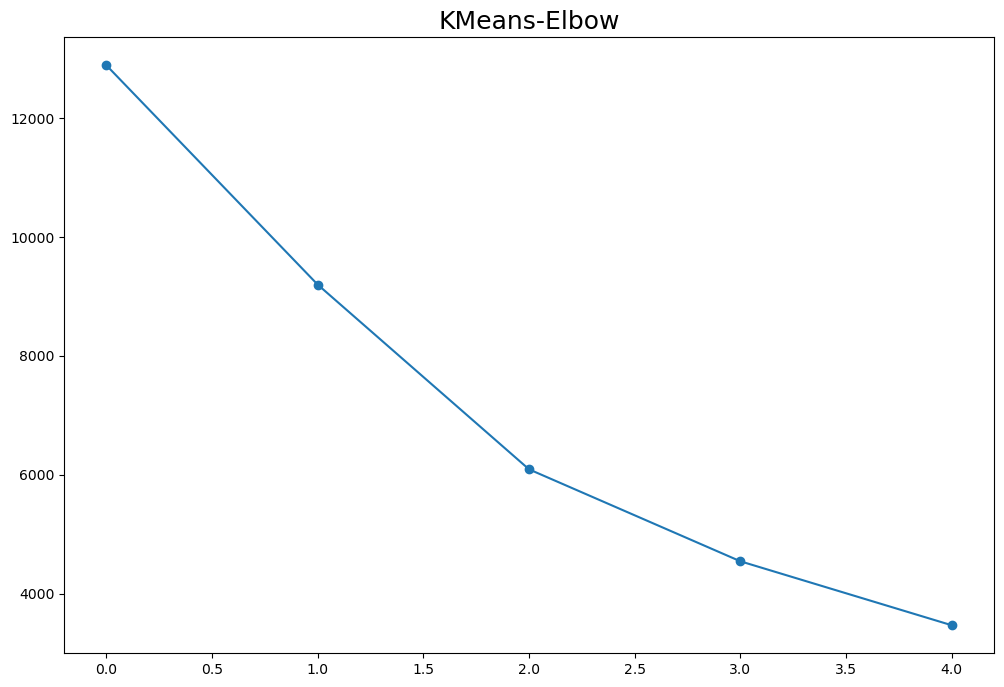

In [10]:
#최적의 클러스터 개수 확인 - 엘보우기법
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

inertia = []

for i in np.arange(1, 6):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(12,8))
plt.plot(inertia, marker='o')
plt.title('KMeans-Elbow', fontsize=18)

In [11]:
#최적의 클러스터를 적용한 kmeans모델
kmeans = KMeans(n_clusters = 3)
kmeans.fit(rfm_scaled)
rfm_data["Cluster_No"] = (kmeans.labels_ + 1)
rfm_data.head()

,Recency,Frequency,Monetary,Cluster_No
CustomerID,,,,
12346.0,347,1,77183.60,2
12347.0,61,7,4310.00,1
12349.0,40,1,1757.55,1
12350.0,332,1,334.40,3
12352.0,94,8,2506.04,1


In [12]:
#군집별 RFM확인
rfm_data.groupby(['Cluster_No'])[['Recency', 'Frequency', 'Monetary']].mean()
# 클러스터1: 중간 레벨의 고객
# 클러스터2: 프리미엄 고객, 구매금액이 크고 최근에 구매한 이력이 있음.
# 클러스터3: 최근 구매일자 이력이 없는 고객, 마케팅이 필요함

,Recency,Frequency,Monetary
Cluster_No,,,
1,68.634429,4.797872,1913.384218
2,48.760000,58.960000,81979.682000
3,281.745299,1.545299,495.484189


c:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


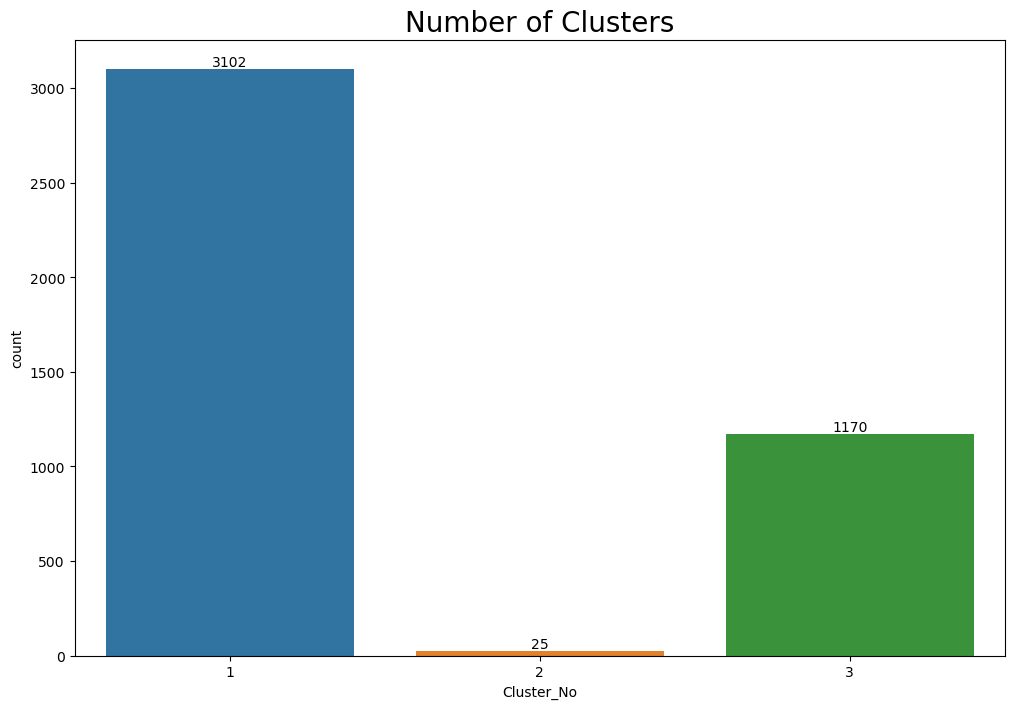

In [13]:
#군집별 수 확인
import seaborn as sns
plt.figure(figsize = (12,8))
ax = sns.countplot(rfm_data.Cluster_No)
plt.title("Number of Clusters", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

In [14]:
#영수증별 품목별 구매 수 집계
# unstack(): 좌에서 우로 쌓아감
data_apr = df.groupby(["BillNo", "Itemname"])[["Quantity"]].sum().unstack().reset_index().fillna(0).set_index("BillNo")
data_apr.head()

Quantity                                                 \
Itemname *Boombox Ipod Classic *USB Office Mirror Ball 10 COLOUR SPACEBOY PEN   
BillNo                                                                          
536365                     0.0                     0.0                    0.0   
536366                     0.0                     0.0                    0.0   
536367                     0.0                     0.0                    0.0   
536368                     0.0                     0.0                    0.0   
536369                     0.0                     0.0                    0.0   

                                                               \
Itemname 12 COLOURED PARTY BALLOONS 12 DAISY PEGS IN WOOD BOX   
BillNo                                                          
536365                          0.0                       0.0   
536366                          0.0                       0.0   
536367                          0.0                       0.0   
536368                          0.0                       0.0   
536369                          0.0                       0.0   

                                                                 \
Itemname 12 EGG HOUSE PAINTED WOOD 12 HANGING EGGS HAND PAINTED   
BillNo                                                            
536365                         0.0                          0.0   
536366                         0.0                          0.0   
536367                         0.0                          0.0   
536368                         0.0                          0.0   
536369                         0.0                          0.0   

                                                                           \
Itemname 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
BillNo                                                                      
536365                                0.0                             0.0   
536366                                0.0                             0.0   
536367                                0.0                             0.0   
536368                                0.0                             0.0   
536369                                0.0                             0.0   

                                        ...                      \
Itemname 12 PENCIL SMALL TUBE WOODLAND  ... wrongly coded 20713   
BillNo                                  ...                       
536365                             0.0  ...                 0.0   
536366                             0.0  ...                 0.0   
536367                             0.0  ...                 0.0   
536368                             0.0  ...                 0.0   
536369                             0.0  ...                 0.0   

                                                                 \
Itemname wrongly coded 23343 wrongly coded-23343 wrongly marked   
BillNo                                                            
536365                   0.0                 0.0            0.0   
536366                   0.0                 0.0            0.0   
536367                   0.0                 0.0            0.0   
536368                   0.0                 0.0            0.0   
536369                   0.0                 0.0            0.0   

                                                           \
Itemname wrongly marked 23343 wrongly marked carton 22804   
BillNo                                                      
536365                    0.0                         0.0   
536366                    0.0                         0.0   
536367                    0.0                         0.0   
536368                    0.0                         0.0   
536369                    0.0                         0.0   

                                                                    \
Itemname wrongly marked. 23343 in box wrongly sold (22719) barcod

In [15]:
def num(x):
    if x <= 0:
        return 0
    elif x >=1:
        return 1
    
basket_new = data_apr.applymap(num)
basket_new.nunique()

          Itemname                    
Quantity  *Boombox Ipod Classic           2
          *USB Office Mirror Ball         2
          10 COLOUR SPACEBOY PEN          2
          12 COLOURED PARTY BALLOONS      2
          12 DAISY PEGS IN WOOD BOX       2
                                         ..
          wrongly marked carton 22804     1
          wrongly marked. 23343 in box    1
          wrongly sold (22719) barcode    2
          wrongly sold as sets            1
          wrongly sold sets               1
Length: 4185, dtype: int64

In [16]:
#Apriori 알고리즘 지지도 > 0.02
from mlxtend.frequent_patterns import apriori
apr = apriori(basket_new, min_support=0.02, use_colnames=True)
apr.sort_values("support", ascending = False)

c:\anaconda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
263,0.108956,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))"
97,0.102128,"((Quantity, JUMBO BAG RED RETROSPOT))"
190,0.094211,"((Quantity, REGENCY CAKESTAND 3 TIER))"
151,0.081940,"((Quantity, PARTY BUNTING))"
122,0.076249,"((Quantity, LUNCH BAG RED RETROSPOT))"
...,...,...
274,0.020139,"((Quantity, WOODEN UNION JACK BUNTING))"
245,0.020139,"((Quantity, STRAWBERRY SHOPPER BAG))"
219,0.020139,"((Quantity, SET OF 60 I LOVE LONDON CAKE CASES))"
195,0.020040,"((Quantity, RIBBON REEL STRIPES DESIGN))"


In [17]:
#향상도 1기준(양의 상관관계가 있는 품목)
from mlxtend.frequent_patterns import association_rules
rules = association_rules(apr, metric="lift", min_threshold=1)
rules.sort_values("confidence", ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
152,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.028204,0.048243,0.025482,0.903509,18.728115,0.024122,9.863659,0.974077
153,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.029936,0.050124,0.025482,0.851240,16.982778,0.023982,6.385280,0.970159
24,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.036418,0.048243,0.029936,0.822011,17.038810,0.028179,5.347273,0.976886
160,"((Quantity, JUMBO BAG PINK POLKADOT), (Quantit...","((Quantity, JUMBO BAG RED RETROSPOT))",0.025433,0.102128,0.020386,0.801556,7.848573,0.017789,4.524572,0.895360
138,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.036418,0.050124,0.028204,0.774457,15.450905,0.026378,4.211500,0.970627
...,...,...,...,...,...,...,...,...,...,...
70,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SKULLS))",0.102128,0.034785,0.020435,0.200097,5.752430,0.016883,1.206665,0.920131
161,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO BAG PINK POLKADOT), (Quantit...",0.102128,0.025433,0.020386,0.199612,7.848573,0.017789,1.217619,0.971840
42,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO BAG ALPHABET))",0.102128,0.043790,0.020336,0.199128,4.547316,0.015864,1.193961,0.868821
131,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, NATURAL SLATE HEART CHALKBOARD))",0.108956,0.060960,0.020336,0.186649,3.061823,0.013695,1.154532,0.755740


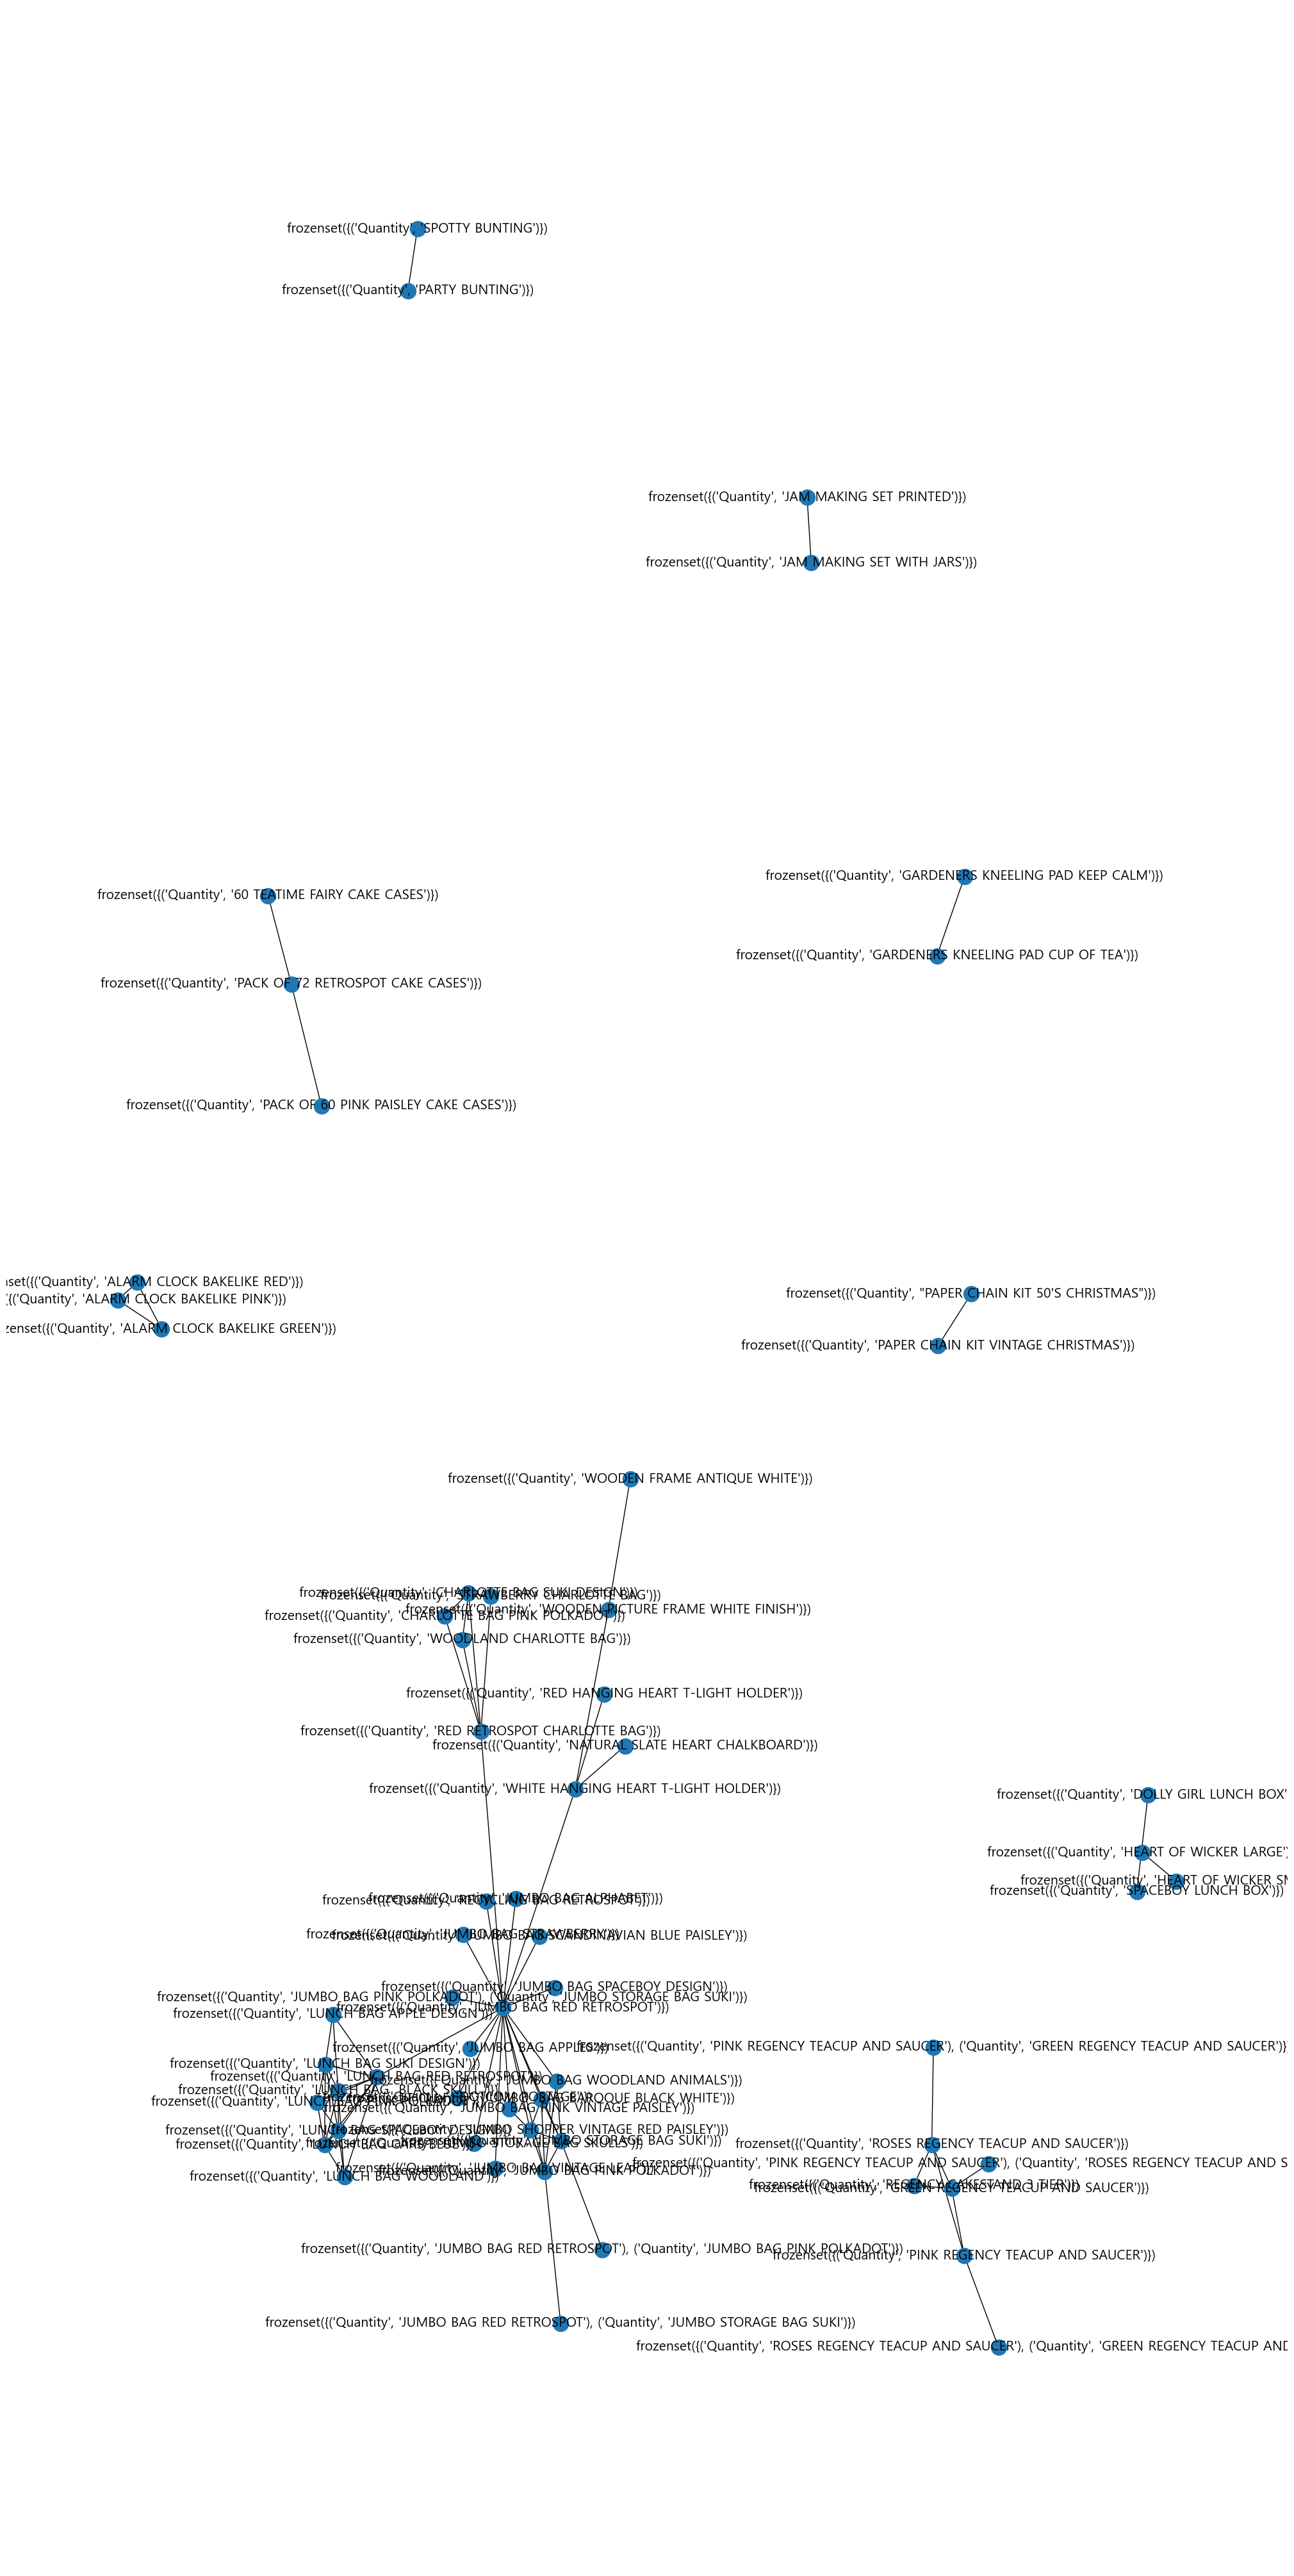

In [18]:
#시각화
from matplotlib import font_manager, rc
# 한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import networkx as nx
ga = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents')
plt.figure(figsize=(20,40))
nx.draw(ga, with_labels=True, font_family=font_name, font_size=15)